# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import pathlib
import json
import cv2
from tqdm import tqdm

# Converting to csv and Visualization

In [2]:
base_dir = pathlib.Path('data/coco/')
train_images = base_dir/'train2017'
valid_images = base_dir/'val2017'
train_labels_json = base_dir/'annotations/instances_train2017.json'
valid_labels_json = base_dir/'annotations/instances_val2017.json'

In [3]:
with open(train_labels_json, 'r') as file:
        data = json.load(file)
idx_to_cat = {cat['id']:cat['name'] for cat in data['categories']}
cat_to_idx = {cat['name']:cat['id'] for cat in data['categories']}

In [4]:
def convert_to_csv(base_dir, images_path, annotations_path, csv_file_name):
    with open(annotations_path, 'r') as file:
        data = json.load(file)
    images = list(images_path.glob('*.jpg'))
    images_data = {}
    for images in data['images']:
        images_data[images['id']] = {'img_name': images['file_name'], 
                                    'height': images['height'],
                                    'width': images['width']}
    complete_data = []
    for annotations in tqdm(data['annotations']):
        current_data = dict()
        image_id = annotations['image_id']
        x1, y1, w, h = annotations['bbox']
        x2, y2 = x1 + w, y1 + h
        category_idx = annotations['category_id']
        category_name = idx_to_cat[category_idx]
        file_name = images_data[image_id]['img_name']
        width = images_data[image_id]['width']
        height = images_data[image_id]['height']

        current_data['image_id'] = image_id
        current_data['file_name'] = file_name
        current_data['width'] = width
        current_data['height'] = height
        current_data['x_1'] = int(x1)
        current_data['y_1'] = int(y1)
        current_data['x_2'] = int(x2)
        current_data['y_2'] = int(y2)
        current_data['category_idx'] = category_idx
        current_data['category_name'] = category_name

        complete_data.append(current_data)
    final_df = pd.DataFrame(complete_data).sort_values(by = 'image_id').reset_index(drop = True)
    final_df.to_csv(base_dir/csv_file_name, index = False)
    return final_df


In [5]:
train_df = convert_to_csv(base_dir, train_images, train_labels_json, 'train.csv')
valid_df = convert_to_csv(base_dir, valid_images, valid_labels_json, 'valid.csv')
train_df.head()

100%|██████████| 36781/36781 [00:00<00:00, 537180.42it/s]


,image_id,file_name,width,height,x_1,y_1,x_2,y_2,category_idx,category_name
0,9,000000000009.jpg,640,480,376,40,451,86,55,orange
1,9,000000000009.jpg,640,480,465,38,523,85,55,orange
2,9,000000000009.jpg,640,480,311,4,631,232,51,bowl
3,9,000000000009.jpg,640,480,249,229,565,474,56,broccoli
4,9,000000000009.jpg,640,480,364,2,458,73,55,orange


__NOTE:__ x_1 is along x axis (column value) and y_1 is along x axis (row value) similarly for x_2, y_2

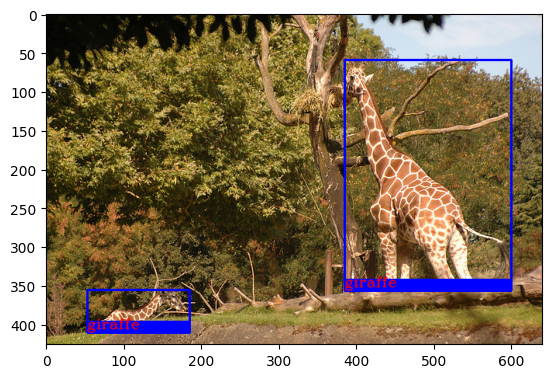

In [6]:
idx = 8
file_name = train_df.iloc[idx]['file_name']
img = cv2.imread(str(train_images/file_name))
df_sub = train_df[train_df['file_name'] == file_name]
for idx, row in df_sub.iterrows():
    img = cv2.rectangle(img, (row['x_1'], row['y_1']), (row['x_2'], row['y_2']), (255, 0, 0), 2)
    img = cv2.rectangle(img, (row['x_1'] - 1, row['y_2'] - 15), (row['x_2'] + 1, row['y_2']), (255, 0, 0), -1)
    img = cv2.putText(img, row['category_name'], (row['x_1'], row['y_2'] - 5), 
                      cv2.FONT_HERSHEY_COMPLEX, 0.6, (0, 0, 255), 1, cv2.LINE_AA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)